# SOLAR: Second-Order Loss and Attention for Image Retrieval

## Image matching visulisation of `solar_local` with `opencv`

Below we show you a quick example of image matching performance, and compare with the baseline `SOSNet` 

In [1]:
import os
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import cv2
import torch
torch.no_grad()

## Initialise SOSNet and SOLAR

In [2]:
import sys
sys.path.insert(0,'..')

from solar_local.models.model import SOLAR_LOCAL, SOSNet32x32
from solar_local.utils import describe_opencv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load the baseline SOSNet
sosnet = SOSNet32x32()
sosnet.load_state_dict(torch.load('../solar_local/weights/sosnet-32x32-liberty.pth'))
sosnet = sosnet.to(device).eval()

solar_local = SOLAR_LOCAL(soa=True, soa_layers='345')
solar_local.load_state_dict(torch.load('../solar_local/weights/local-solar-345-liberty.pth'))
solar_local = solar_local.to(device).eval()

SOLAR_LOCAL - SOSNet w/ SOA layers:
SOA_3:
Num channels:    in   out   mid
                 64    64    16
SOA_4:
Num channels:    in   out   mid
                 64    64    16
SOA_5:
Num channels:    in   out   mid
                128   128    64


## Read images, detect keypoints and describe using SOSNet & SOLAR

In [3]:
# Load the images and detect BRISK keypoints using openCV
img1 = cv2.imread('../assets/matching_img1.jpg', 0)
img2 = cv2.imread('../assets/matching_img2.jpg', 0)

brisk = cv2.BRISK_create(100)
kp1 = brisk.detect(img1, None)
kp2 = brisk.detect(img2, None)

# We use the tfeat_utils methods that rectify patches around openCV keypoints and 
sosnet_desc_1 = describe_opencv(sosnet, img1, kp1, patch_size=32, mag_factor=3)
sosnet_desc_2 = describe_opencv(sosnet, img2, kp2, patch_size=32, mag_factor=3)

solar_desc_1 = describe_opencv(solar_local, img1, kp1, patch_size=32, mag_factor=3)
solar_desc_2 = describe_opencv(solar_local, img2, kp2, patch_size=32, mag_factor=3)

## Brute-force matching with `opencv` 

In [4]:
bf = cv2.BFMatcher(cv2.NORM_L2)
matches_sosnet = bf.knnMatch(sosnet_desc_1, sosnet_desc_2, k=2)
matches_solar = bf.knnMatch(solar_desc_1, solar_desc_2, k=2)

Here, we use the same ratio for both descriptors (0.8, same as that from [here](https://github.com/scape-research/SOSNet/blob/master/SOSNet-demo.ipynb)) in the ratio test

In [5]:
# Apply SIFT's ratio test, notice that 0.8 may not be the best ratio for SOSNet
good_sosnet = []
good_solar = []
ratio = 0.8

for m,n in matches_sosnet:
    if m.distance < ratio*n.distance:
        good_sosnet.append([m])
        
for m,n in matches_solar:
    if m.distance < ratio*n.distance:
        good_solar.append([m])
       
print('Number of matches: SOSNet {} | SOLAR {}'.format(len(good_sosnet), len(good_solar)))

Number of matches: SOSNet 34 | SOLAR 39


You can see that SOLAR gives 15% more matches in this very naive example

## Visualising

Now we plot the matches between the two images, for both descriptors, and save them as images

In [6]:
sosnet_img_matches = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_sosnet, 0, flags=2)
solar_img_matches = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_solar, 0, flags=2)

We can also see the results with `matplotlib` here

<IPython.core.display.Javascript object>


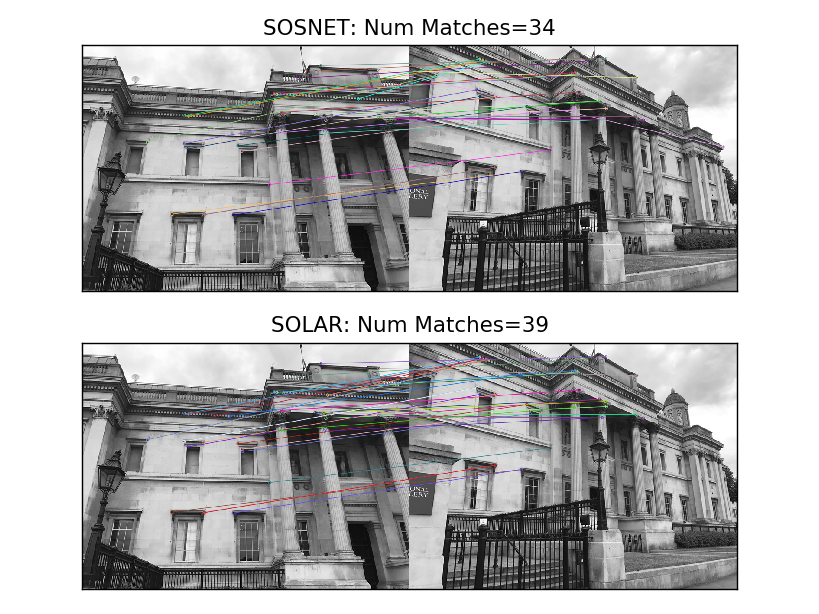

In [7]:
cv2.imwrite("sosnet-matches.png", sosnet_img_matches)
cv2.imwrite("solar-matches.png", solar_img_matches)

fig = plt.figure(dpi=160)
ax_sosnet = fig.add_subplot(211)
ax_solar = fig.add_subplot(212)

for ax in [ax_sosnet, ax_solar]:
    ax.set_xticks([])
    ax.set_yticks([])

ax_sosnet.imshow(sosnet_img_matches)
ax_sosnet.set_title("SOSNET: Num Matches={}".format(len(good_sosnet)))
ax_solar.imshow(solar_img_matches)
ax_solar.set_title("SOLAR: Num Matches={}".format(len(good_solar)))

plt.tight_layout()
plt.show()

If you look closely, SOLAR actually avoids an obvious wrong match that is present in SOSNet's example (top right of the left image matched to the right-end of the building in the right image)